# $Q_{CO_2}$ and $\text{ln}(S_{CO_2/N_2})$ DREAMING EXPERIMENTS

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
# imports
import sys, os
sys.path.append('../../deep_dream_src/')
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import random
from plot_utils import draw_smiles_linker, create_parity_plot
from nn_functions import featurize_df, prepare_hybrid_dataset, MolecularLSTMModel, split_dataframe
from utils import *
from tokenizer_functions import *
import selfies as sf
from group_selfies import GroupGrammar, bond_constraints
import math
import pickle 
group_constraints = {'H': 1, 'F': 1, 'Cl': 1, 'Br': 1, 'I': 1, 'B': 3, 'B+1': 2, 'B-1': 4, 'O': 2, 'O+1': 3, 'O-1': 1, 'N': 3, 'N+1': 4, 'N-1': 2, 'C': 4, 'C+1': 3, 'C-1': 3, 'P': 5, 'P+1': 6, 'P-1': 4, 'S': 6, 'S+1': 7, 'S-1': 5, '?': 8, '*': math.inf, 'Fr': 1}
bond_constraints.set_semantic_constraints(group_constraints)
from dreaming_functions import *
import rdkit
from rdkit import Chem 
rdkit.RDLogger.DisableLog('rdApp.warning')

### Collect our input data

In [4]:
training_data = pd.read_csv('../../train_models/training_data.csv')
group_grammar = GroupGrammar.from_file('../gs_mof_grammar.txt')
training_data.head(1)

,edge_selfie,edge_canon_smile,edge_group_selfie,group_selfie_length,node_selfie,topo,SA_score,connection_point,MOFname,totalPOV_VF,...,GSA,henry_coefficient_CO2_300_mol_kg_Pa,log_henry_coefficient_CO2_300,heat_of_adsorption_CO2_300_kJ_mol,henry_coefficient_N2_300_mol_kg_Pa,log_henry_coefficient_N2_300,heat_of_adsorption_N2_300_kJ_mol,henry_CO2_N2_selectivity,log_CO2_N2_selectivity,filename
0,[O][O][C][=C][C][Branch1][C][Fr][C][Branch1][R...,OOC1=CC([Fr])C(OO)=CC1=C1NN([Fr])N1,[O][O][C][=C][C][Branch][C][=Branch][=C][C][Br...,28,[Fr][C][O][Cu][O][C][Branch1][C][Fr][O][Cu][Br...,acs,5.938156,"[11, 27]",acs_N125_edge1276,0.7545,...,4100.11,0.000005,-12.2,-10.097733,0.000002,-13.3,-4.43999,2.92,1.072161,acs_N125_edge1276.cif


In [5]:
training_data.head(1)

,edge_selfie,edge_canon_smile,edge_group_selfie,group_selfie_length,node_selfie,topo,SA_score,connection_point,MOFname,totalPOV_VF,...,GSA,henry_coefficient_CO2_300_mol_kg_Pa,log_henry_coefficient_CO2_300,heat_of_adsorption_CO2_300_kJ_mol,henry_coefficient_N2_300_mol_kg_Pa,log_henry_coefficient_N2_300,heat_of_adsorption_N2_300_kJ_mol,henry_CO2_N2_selectivity,log_CO2_N2_selectivity,filename
0,[O][O][C][=C][C][Branch1][C][Fr][C][Branch1][R...,OOC1=CC([Fr])C(OO)=CC1=C1NN([Fr])N1,[O][O][C][=C][C][Branch][C][=Branch][=C][C][Br...,28,[Fr][C][O][Cu][O][C][Branch1][C][Fr][O][Cu][Br...,acs,5.938156,"[11, 27]",acs_N125_edge1276,0.7545,...,4100.11,0.000005,-12.2,-10.097733,0.000002,-13.3,-4.43999,2.92,1.072161,acs_N125_edge1276.cif


In [6]:
target_names = ['heat_of_adsorption_CO2_300_kJ_mol', 'log_CO2_N2_selectivity']

mof_selfies_encoding, tokenized_info = featurize_df(
    training_data,
    target_names,
    edge_rep = 'edge_group_selfie',
    node_rep = 'node_selfie',
    topo_rep = 'topo'
    )

samples = 10000
split_by = {
    'method': 'sample',
    'train': samples,
    'validate': 1000,
    'test': 1000
    }

train_df, validate_df, test_df = split_dataframe(mof_selfies_encoding, split_by, seed=42)

../../deep_dream_src\nn_functions.py:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_featurize['tokenized_edge_selfies'] = tokenized_selfies
../../deep_dream_src\nn_functions.py:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_featurize['edge_lens'] = edge_lens
../../deep_dream_src\nn_functions.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

# Load Language Models

In [8]:
dream_name = 'noise_06_CO2_hoa_selectivity'
predictor_name = 'noise_00_CO2_hoa_selectivity'

with open('../../train_models/mof_saved_models/{}.pkl'.format(dream_name), 'rb') as f:
    dream_train_info = pickle.load(f)
scaler = dream_train_info['scaler']
tokenized_info = dream_train_info['tokenized_info']
dream_train_info['hyperparams']['num_layers'] = 1     # For some reason the model saved layers using a tuple
dream_hyperparams = dream_train_info['hyperparams']

with open('../../train_models/mof_saved_models/{}.pkl'.format(predictor_name), 'rb') as f:
    predictor_train_info = pickle.load(f)
predictor_train_info['hyperparams']['num_layers'] = 1     # For some reason the model saved layers using a tuple
predictor_hyperparams = predictor_train_info['hyperparams']
predictor_scaler = predictor_train_info['scaler']

c:\Users\x82753cc\AppData\Local\anaconda3\envs\deep_dreaming\lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.3.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [9]:
dreaming_model = MolecularLSTMModel(**dream_hyperparams)
dreaming_model.load_state_dict(dream_train_info['model_state_dict'])
predictor_model = MolecularLSTMModel(**predictor_hyperparams)
predictor_model.load_state_dict(predictor_train_info['model_state_dict'])

<All keys matched successfully>

## Test model

(1000, 2)


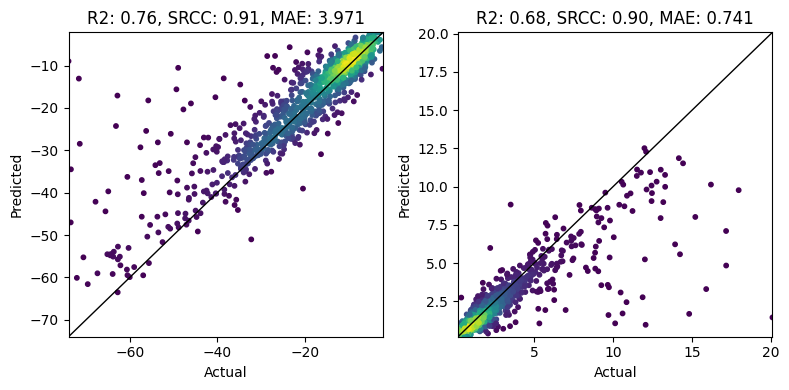

In [10]:
validate_loader, _ = prepare_hybrid_dataset(test_df,tokenized_info,target_names,pad_node=False,batch_size=1,shuffle=True,train=False,scaler=predictor_scaler,noise_level=predictor_train_info['noise_level'])
create_parity_plot(predictor_model, predictor_scaler, validate_loader)

# Dreaming 

#### Lets perform a dreaming operation

In [27]:
idx = 9
seed_mof_string = train_df.iloc[idx]['mof_string']
train_df.iloc[idx]

MOFname                                                            dmp_N553_edge162292
edge_group_selfie                    [:0alkene][C][C][Branch][C][=C][C][Branch][C][...
node_selfie                          [Fr][C][C][=C][N][Branch1][Branch1][C][C][=Rin...
topo                                                                               dmp
heat_of_adsorption_CO2_300_kJ_mol                                            -5.690989
log_CO2_N2_selectivity                                                         0.51149
tokenized_edge_selfies               [7, 61, 61, 60, 61, 52, 61, 60, 61, 68, 69, 72...
edge_lens                                                                           22
node_plus_topo                       [Fr][C][C][=C][N][Branch1][Branch1][C][C][=Rin...
tokenized_node_plus_topo             [34, 22, 22, 7, 45, 20, 20, 22, 22, 11, 5, 65,...
node_plus_topo_lens                                                                 86
mof_string                           [:0alk

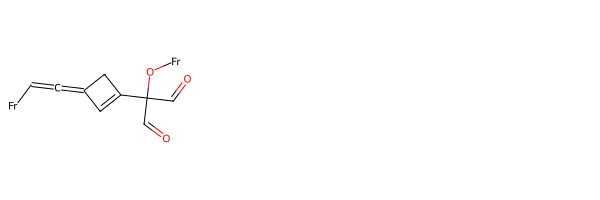

In [26]:
# Lets visualise the seed linker
draw_smiles_linker([Chem.MolToSmiles(group_grammar.decoder(train_df.iloc[idx]['edge_group_selfie']))])

In [30]:
dream_settings = {
    'num_epochs': 5000,
    'lr': 0.001,
    'penalty_per_connection': 0.1,
    'SA_penalty_scaler': 0.1,
    'patience': 100,
    'noise_level': dream_train_info['noise_level'],
    'target_tolerance': 0.1
    }

target_values = [0, 1]

valid_opt_pathway, transmutation_pathway, dreaming_losses = dream(
    dreaming_model,
    predictor_model,
    seed_mof_string,
    target_values,
    tokenized_info,
    group_grammar, 
    dream_settings
    )

torch.Size([1, 39, 73])
Restored variables from c:\Users\x82753cc\OneDrive - The University of Manchester\github_repositories\deep_dreaming_MOFs\deep_dream_src\scscore_1024uint8_model.ckpt-10654.as_numpy.json.gz
seed value: [0.8881307  0.15927988] | target value: [0. 1.] | opt_flag: ['min', 'max']


opt flag: max, all targets: [0.8942929  0.15554214], valid linker, valid distance point
opt flag: max, all targets: [0.8942929  0.15554214], valid linker, invalid distance point
opt flag: max, all targets: [0.8942929  0.15554214], valid linker, invalid distance point
opt flag: max, all targets: [0.8942929  0.15554214], valid linker, invalid distance point
opt flag: max, all targets: [0.8641476  0.16467972], valid linker, valid distance point
opt flag: max, all targets: [0.8641476  0.16467972], valid linker, invalid distance point
opt flag: max, all targets: [0.8641476  0.16467972], valid linker, invalid distance point
opt flag: max, all targets: [0.68344355 0.20088094], valid linker, valid 

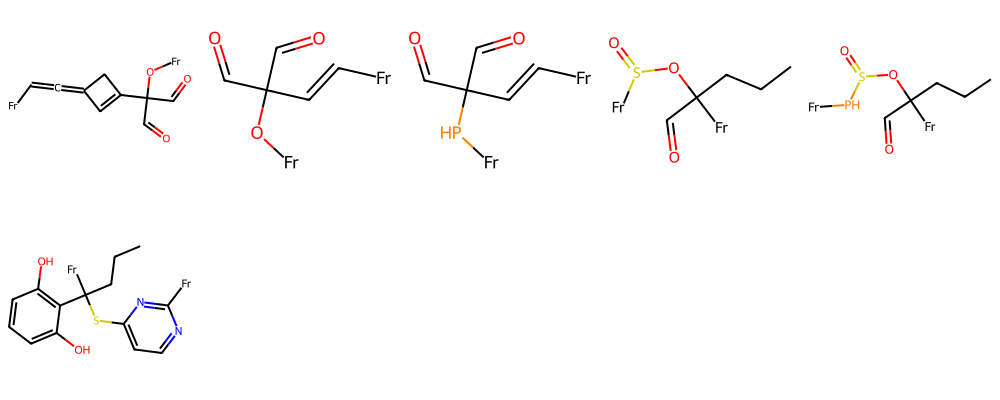

In [31]:
draw_smiles_linker(valid_opt_pathway['dreamed_smiles'],molsPerRow=5,subImgSize=(200, 200),line_width=2)

#### Shited property distributions

In [ ]:
# ******************* EXAMPLE CELL TO OPTIMISE MULTIOBJECTIVE DISTRIBUTION *******************

# Seed distribution
seed = pd.read_csv(('../seeds/hoa_selectivity_1000_seed_df.csv'))
target_values = [0, 1]     # min(Q_CO2), max(ln(α_CO2/N2))

# Dream settings
dream_settings = {
    'num_epochs': 1000,
    'lr': 0.001,
    'penalty_per_connection': 0.1,
    'SA_penalty_scaler': 0.1,
    'patience': 100,
    'noise_level': dream_train_info['noise_level'],
    'target_tolerance': 0.1
    }

# Perform dreaming for a distribution of cp MOFs
dream_results = []
exceptions = []
start, stop = 0, 10
count = 0
for i in range(start,stop): 
    print(i)
    try:
        global_opt_pathways = []
        for j in range(10): 
            seed_mof_string = seed.iloc[i]['mof_string']
            opt_mof_string = seed_mof_string
            local_valid_opt_pathway = run_dream_exp(
                dreaming_model, 
                predictor_model, 
                opt_mof_string, 
                target_values, 
                tokenized_info, 
                group_grammar, 
                dream_settings,
                iterations=5
                )
            global_opt_pathways.append(local_valid_opt_pathway)
        
        # extract the pathway with the best target value (ensemble of local optimisations)
        if target_values[0] <= 0:
            valid_opt_pathway = global_opt_pathways[np.argmin([pathway.iloc[-1]['predictor_targets'][0] for pathway in global_opt_pathways])]
        elif target_values[0] >= 1:
            valid_opt_pathway = global_opt_pathways[np.argmax([pathway.iloc[-1]['predictor_targets'][0] for pathway in global_opt_pathways])]
        else:
            raise ValueError('Target value must be <= 0 or >= 1')

        # store results in new dataframe
        dream_results.append({
            'seed_mof_name': seed.iloc[i]['MOFname'],
            'seed_mof_string': seed_mof_string,
            'seed_edge_selfies': seed.iloc[i]['edge_group_selfie'],
            'seed_target': seed.iloc[i][target_names[0]],
            'dreamed_mof_string': valid_opt_pathway.iloc[-1]['dreamed_mof_string'],
            'dreamed_edge_selfies': valid_opt_pathway.iloc[-1]['dreamed_selfies'],
            'dreamed_edge_smiles': valid_opt_pathway.iloc[-1]['dreamed_smiles'],
            'dreamed_target': scaler.inverse_transform(np.array(valid_opt_pathway.iloc[-1]['predictor_targets'][0]).reshape(1, -1)).item(),
        })
        count += 1
        if count % 5 == 0:
            dream_results_df = pd.DataFrame(dream_results)
            dream_results_df.to_csv(f'./dream_results/{start}_{stop}_{target_names[0]}_dream_results_TEST.csv')    	
    except Exception as e:
        exceptions.append(e)
        continue
dream_results_df = pd.DataFrame(dream_results)
dream_results_df.to_csv(f'./dream_results/{start}_{stop}_{target_names[0]}_dream_results_TEST.csv')

#### Let's visualise the dreaming results

In [30]:
dream_results_df = pd.read_csv('./dream_results/hoa_selectivity_dream_results.csv')

In [31]:
dream_results_df.head(1)

,seed_mof_name,seed_mof_string,seed_edge_selfies,seed_edge_smiles,seed_targets,dreamed_mof_string,dreamed_edge_selfies,dreamed_edge_smiles,dreamed_targets,dreamed_mof_name,linker_hash
0,sra_N34_edge148295,[:0O_nitrile][C][C][Branch][C][=Branch][=C][Br...,[:0O_nitrile][C][C][Branch][C][=Branch][=C][Br...,N#COC(CC(O)[Fr])C(O)=C(O)C(O)C[Fr],"[-7.0946636, 0.66457623]",[:0sulfonic_acid][S][S][Branch][:1alkyne][:0be...,[:0sulfonic_acid][S][S][Branch][:1alkyne][:0be...,CCC#C[SH](c1c(O)ccc(-c2ncccc2-c2cc(-c3c(O)ccc(...,"[-10.2137584619, 1.0382040202989056]",sra_N34_f443cb51,f443cb51


In [32]:
dream_results_df['dreamed_target1'] = dream_results_df['dreamed_targets'].apply(lambda x: eval(x)[0])
dream_results_df['dreamed_target2'] = dream_results_df['dreamed_targets'].apply(lambda x: eval(x)[1])
dream_results_df['seed_target1'] = dream_results_df['seed_targets'].apply(lambda x: eval(x)[0])
dream_results_df['seed_target2'] = dream_results_df['seed_targets'].apply(lambda x: eval(x)[1])


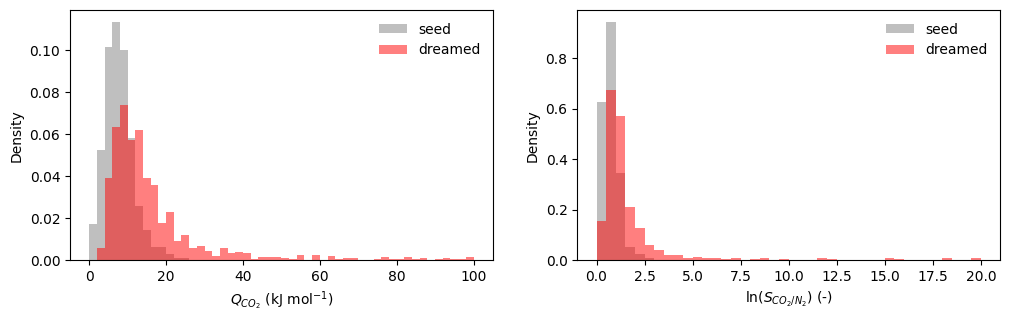

In [36]:
fig,ax= plt.subplots(1,2,figsize=(12,3.25))
ax[0].hist(-dream_results_df['seed_target1'], bins=np.arange(0, 100 + 2, 2),alpha=0.5,density=True,label='seed',color='grey')
ax[0].hist(-dream_results_df['dreamed_target1'], bins=np.arange(0, 100 + 2, 2), alpha=0.5, density=True,label='dreamed',color='red')
ax[0].set(xlabel='$Q_{CO_2}$ ($\mathregular{kJ\ mol^{-1}}$)',ylabel='Density')
ax[0].legend(frameon=False)

ax[1].hist(dream_results_df['seed_target2'],bins=np.arange(0, 20 + 0.5, 0.5),alpha=0.5,density=True,label='seed',color='grey')
ax[1].hist(dream_results_df['dreamed_target2'],bins=np.arange(0, 20 + 0.5, 0.5),alpha=0.5,density=True,label='dreamed',color='red')
ax[1].set(xlabel='ln($S_{CO_2/N_2}$) (-)',ylabel='Density')
ax[1].legend(frameon=False)
plt.show()
fig.savefig('dream_distributions.png',dpi=500,bbox_inches="tight")

#### Attention weight distributions

In [37]:
# Redefining the split_selfies function and the checking function after reset
def split_selfies(s):
    return s.strip('[]').split('][')

# Generalized function to match base tokens with a list of split tokens
def check_base_occurrences(base_tokens, split_tokens):
    incidence_count = {base_token: 0 for base_token in base_tokens}
    
    # Normalize base tokens for matching
    normalized_base_tokens = [f"[{token}]" for token in base_tokens]
    
    for split_token in split_tokens:
        # Remove any leading colons and numbers (e.g., '[:0', '[:1', etc.)
        normalized_split_token = "[" + split_token.split(']')[0].lstrip('[:0123456789=') + "]"
        
        if normalized_split_token in normalized_base_tokens:
            original_token = normalized_split_token.strip('[]')
            incidence_count[original_token] += 1
    
    return incidence_count

# Function to count and compute percentage incidence rates for the entire list
def compute_percentage_incidence(tokens, strings):
    total_strings = len(strings)
    incidence_counts = {token: 0 for token in tokens}
    
    for string in strings:
        split_tokens = split_selfies(string)
        incidence = check_base_occurrences(tokens, split_tokens)
        for token, count in incidence.items():
            if count > 0:
                incidence_counts[token] += 1
    
    percentage_incidence = {token: (count / total_strings) * 100 for token, count in incidence_counts.items()}
    
    return percentage_incidence

# Modified approach to group similar keys (ignoring the number after the colon)
def normalize_key(key):
    if key.startswith('[:#'):
        return '['+key[4:]
    elif key.startswith('[:='):
        return '['+key[4:]
    elif key.startswith('[:'):
        return '['+key[3:]
    else:
        return key

special_categories = {'S', 'Cl', 'F', 'Br', 'P'}

# Function to count the incidence rate of each category
def count_incidence_percentage(data, special_categories):
    total_entries = len(data)
    incidence_counts = {cat: 0 for cat in special_categories}

    for entry in data:
        for element in entry:
            if element in special_categories:
                incidence_counts[element] += 1
                # break  # Count once per entry if any special category is found
    
    # Convert counts to percentages
    incidence_percentages = {cat: (count / total_entries) * 100 for cat, count in incidence_counts.items()}
    return incidence_percentages



In [38]:
cleaned_selfies = [group_grammar.full_encoder(Chem.MolFromSmiles(smi)) for smi in dream_results_df['dreamed_edge_smiles']]
dream_results_df['cleaned_dreamed_edge_selfies'] = cleaned_selfies

In [39]:
# Example lists and usage
tokens_list = [
    "methyl",
    "propyl",
    "alkyne",
    "carboxylic_acid",
    "alkene",
    "methyl_amine",
    "nitrile",
    "amide",
    "isocyanate",
    "O_nitrile",
    "sulfonic_acid",
    "phosphoric_acid",
    "benzene",
    "benzenealcohol",
    "benzenediol",
    "pyrimidine",
    "pyridine",
    "imidazole"
]

In [40]:
# Get the attention weights of the training dataframe strings
target_names = ['heat_of_adsorption_CO2_300_kJ_mol']

mof_selfies_encoding, tokenized_info = featurize_df(
    train_df,
    target_names,
    edge_rep = 'edge_group_selfie',
    node_rep = 'node_selfie',
    topo_rep = 'topo'
    )

train_attn_scores = []
for i in range(len(mof_selfies_encoding)):
    try:
        mof_string = mof_selfies_encoding['mof_string'].iloc[i]
        predicted_targets, attn_w1, attn_w2 = predict_kpi(predictor_model,mof_string,tokenized_info)
        gs = mof_selfies_encoding['edge_group_selfie'].iloc[i]
        len_edge_selfies = sf.len_selfies(gs)
        attn_scores = attn_w1.detach().numpy().flatten()[:len_edge_selfies+1] / np.sum(attn_w1.detach().numpy().flatten()[:len_edge_selfies+1])
        token_attn_scores = {}
        split_tokens = list(sf.split_selfies(gs))
        for j in range(len(split_tokens)):
            token_attn_scores[split_tokens[j]] = attn_scores[j]
        train_attn_scores.append(token_attn_scores)
    except:
        continue

../../deep_dream_src\nn_functions.py:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_featurize['tokenized_edge_selfies'] = tokenized_selfies
../../deep_dream_src\nn_functions.py:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_featurize['edge_lens'] = edge_lens
../../deep_dream_src\nn_functions.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

torch.Size([1, 39, 73])
torch.Size([1, 39, 73])
torch.Size([1, 39, 73])
torch.Size([1, 39, 73])
torch.Size([1, 39, 73])
torch.Size([1, 39, 73])
torch.Size([1, 39, 73])
torch.Size([1, 39, 73])
torch.Size([1, 39, 73])
torch.Size([1, 39, 73])
torch.Size([1, 39, 73])
torch.Size([1, 39, 73])
torch.Size([1, 39, 73])
torch.Size([1, 39, 73])
torch.Size([1, 39, 73])
torch.Size([1, 39, 73])
torch.Size([1, 39, 73])
torch.Size([1, 39, 73])
torch.Size([1, 39, 73])
torch.Size([1, 39, 73])
torch.Size([1, 39, 73])
torch.Size([1, 39, 73])
torch.Size([1, 39, 73])
torch.Size([1, 39, 73])
torch.Size([1, 39, 73])
torch.Size([1, 39, 73])
torch.Size([1, 39, 73])
torch.Size([1, 39, 73])
torch.Size([1, 39, 73])
torch.Size([1, 39, 73])
torch.Size([1, 39, 73])
torch.Size([1, 39, 73])
torch.Size([1, 39, 73])
torch.Size([1, 39, 73])
torch.Size([1, 39, 73])
torch.Size([1, 39, 73])
torch.Size([1, 39, 73])
torch.Size([1, 39, 73])
torch.Size([1, 39, 73])
torch.Size([1, 39, 73])
torch.Size([1, 39, 73])
torch.Size([1, 3

In [41]:
# Re-compute distributions and averages with correctly normalized keys
from collections import defaultdict
distributions = defaultdict(list)
averages = {}

for d in train_attn_scores:
    for key, value in d.items():
        key = normalize_key(key)
        distributions[key].append(value)

for key in distributions:
    averages[key] = np.mean(distributions[key])

# Convert correct normalized distributions to a format that's easy to print or analyze
distributions_for_display = {key: distributions[key] for key in distributions}

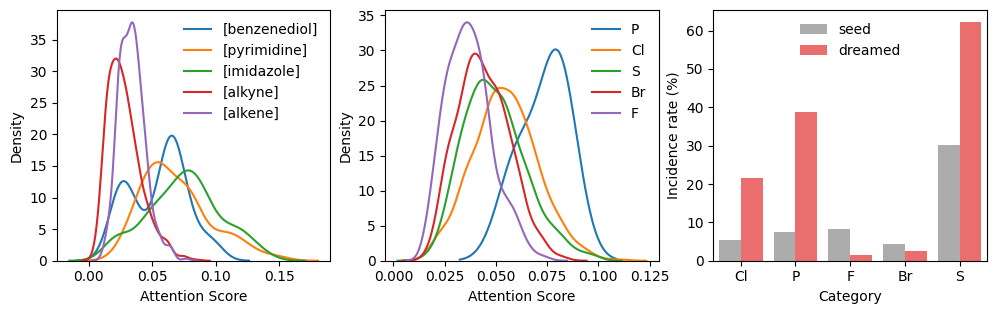

In [43]:
import seaborn as sns
from utils import get_molecule_composition

fig, ax = plt.subplots(1,3,figsize=(12,3.25))

# Get molecule compositions to check for elemental functional groups
special_categories = {'S', 'Cl', 'F', 'Br', 'P'}
data1 = [get_molecule_composition(x) for x in dream_results_df['seed_edge_smiles']]
data2 = [get_molecule_composition(x) for x in dream_results_df['dreamed_edge_smiles']]

# plot the attention score distributions
sns.kdeplot(distributions_for_display['[benzenediol]'], label='[benzenediol]', ax=ax[0])
sns.kdeplot(distributions_for_display['[pyrimidine]'], label='[pyrimidine]', ax=ax[0])
sns.kdeplot(distributions_for_display['[imidazole]'], label='[imidazole]', ax=ax[0])
sns.kdeplot(distributions_for_display['[alkyne]'], label='[alkyne]', ax=ax[0])
sns.kdeplot(distributions_for_display['[alkene]'], label='[alkene]', ax=ax[0])
ax[0].set(ylabel='Density',xlabel='Attention Score')
ax[0].legend(frameon=False)

sns.kdeplot(distributions_for_display['[=P]'], label='P', ax=ax[1])
sns.kdeplot(distributions_for_display['[Cl]'], label='Cl', ax=ax[1])
sns.kdeplot(distributions_for_display['[=S]'], label='S', ax=ax[1])
sns.kdeplot(distributions_for_display['[Br]'], label='Br', ax=ax[1])
sns.kdeplot(distributions_for_display['[F]'], label='F', ax=ax[1])
ax[1].set(ylabel='Density',xlabel='Attention Score')
ax[1].legend(frameon=False)

# Counting the incidence for both datasets
incidence_data1 = count_incidence_percentage(data1, special_categories)
incidence_data2 = count_incidence_percentage(data2, special_categories)

# Prepare the data for plotting
incidence_df = pd.DataFrame({
    'Category': list(incidence_data1.keys()) + list(incidence_data2.keys()),
    'Incidence': list(incidence_data1.values()) + list(incidence_data2.values()),
    'Dataset': ['seed']*len(incidence_data1) + ['dreamed']*len(incidence_data2)
})

# Plotting the bar plot for the incidence rate
# sns.barplot(data=incidence_df, x='Category', y='Incidence', hue='Dataset', palette="muted",ax=ax[2])
ax[2].set(ylabel='Incidence rate (%)',xlabel='')
sns.barplot(data=incidence_df, x='Category', y='Incidence', hue='Dataset', palette=["grey", "red"], alpha=0.65, ax=ax[2])
ax[2].legend(frameon=False,loc='upper center')
# plt.show()
# plt.tight_layout()
fig.savefig('attention_weights.png',dpi=500,bbox_inches="tight")